In [1]:
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import forestci as fci


Failed to import duecredit due to No module named 'duecredit'


In [2]:
signal = pd.read_csv("resonances0.txt", delim_whitespace=True)
val_data = pd.read_csv("comp.txt", delim_whitespace=True)

In [32]:
signal.shape, signal.head()

((283, 12),
     Z  El   A   Io      Bn    D0   dD   S0   dS    Gg   dG Com.
 0  20  Ca  40  0.0   8.363  45.0  4.0  2.7  0.7  1500  900  06M
 1  20  Ca  42  0.0   7.933  20.0  5.0  2.5  0.5  1100  200  96I
 2  20  Ca  43  3.5  11.131   1.8  0.3  3.6  0.6   750   40  96I
 3  20  Ca  44  0.0   7.415  24.1  3.2  2.4  0.5  1300  400  96I
 4  21  Sc  45  3.5   8.761   1.3  0.1  4.4  0.6   840  460  96I)

In [4]:
x = signal[['Z','A']]
y = signal[['D0','dD']]
arr_x = x.values.reshape(-1,2)
arr_y = y.values.reshape(-1,2)
arr_y_pred, arr_y_err = np.hsplit(arr_y,2)
arr_y_err = arr_y_err.ravel()
arr_y_pred = arr_y_pred.ravel()

In [5]:
a_inc = signal[['A']] + 1
arr_a_inc = a_inc.values.reshape(-1,1)
arr_a_inc = arr_a_inc.ravel()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(arr_x, arr_y, test_size=0.2, random_state=11)

X_train_inc = pd.DataFrame(X_train, columns=['Z','A'])
X_train_inc['A'] = X_train_inc['A'] + 1
arr_X_train_inc = X_train_inc.values.reshape(-1,2)

X_test_inc = pd.DataFrame(X_test, columns=['Z','A'])
X_test_inc['A'] = X_test_inc['A'] + 1
arr_X_test_inc = X_test_inc.values.reshape(-1,2)

y_train, y_train_dd = np.hsplit(y_train,2)
y_test, y_test_dd = np.hsplit(y_test,2)

y_train = y_train.ravel() 
y_test = y_test.ravel()
y_test_dd = y_test_dd.ravel()

In [7]:
rf = RandomForestRegressor(n_estimators=500,max_depth=50,random_state=10,max_features=2)
rf.fit(X_train,y_train)
score = rf.score(X_train,y_train)
y_pred = rf.predict(X_test)
rf_err = abs(fci.random_forest_error(rf,X_train,X_test,calibrate=False))
mse = mean_squared_error(y_test, y_pred)

In [8]:
test_data = pd.read_csv("test.txt", delim_whitespace=True)
test_data = test_data[['Z','A']]
arr_test_data = test_data.values.reshape(-1,2)
test_data_inc = test_data[['A']]+1
arr_test_data_inc = test_data_inc.values.reshape(-1,1)
arr_test_data_inc = arr_test_data_inc.ravel()

In [9]:
# test_data = pd.read_csv("res_general.txt", delim_whitespace=True)
# test_data = test_data[['Z','A']]

# res = rf.predict(X_test)
# rf_err = abs(fci.random_forest_error(rf,X_train,X_test,calibrate=False))
# print(test_data)

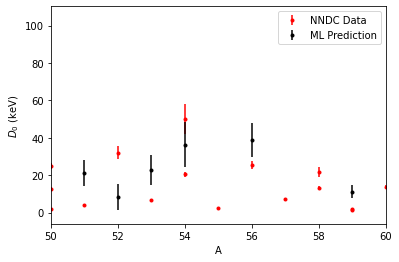

In [43]:
plt.errorbar(signal['A'],signal['D0'],yerr=signal['dD'],fmt='o',markersize=3, color='red',label='NNDC Data')
# plt.fill_between(signal['Z'], y_pred - np.sqrt(rf_err), y_pred + np.sqrt(rf_err), alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF',label='ML Error')
plt.errorbar(X_test[:,1],y_pred,yerr=np.sqrt(rf_err),fmt='o',markersize=3, color='black',label='ML Prediction')
#plt.errorbar(val_data['Z'],val_data['D0'],yerr=val_data['dD'],fmt='o',markersize=3, color='Green',label='Comparison Data')

plt.xlim(50,60)
# plt.ylim(0,10)

plt.legend()
plt.xlabel("A")
plt.ylabel("$D_0$ (keV)")
plt.show()

In [11]:
# total_errs = [np.sqrt(rf_err[i] + float(y_test_dd[i])**2) for i in np.arange(len(X_test))]
ratio = [round(y_pred[i] / y_test[i],4) for i in np.arange(len(y_pred))]
ratio_err = [round(ratio[i]*np.sqrt((rf_err[i] / (y_pred[i])**2) + (float(y_test_dd[i]) / y_test[i])**2),4) for i in np.arange(len(y_pred))]

In [12]:
with open("data.txt","w") as f:
    f.write('# Basic Learning Model - Validating Test Case - Score: {0} - MSE: {1} \n'.format(round(score,4),round(mse,4)))
    f.write('#Z   A   D0   dD   mlD0   mldD   mlD0/D0   d(mlD0/D0) \n')
    for i in range(0, len(y_pred)):
        f.write("{0}   {1}   {2}   {3}   {4}   {5}   {6}   {7}\n".format(arr_X_test_inc[i,0],arr_X_test_inc[i,1],y_test[i],y_test_dd[i],round(y_pred[i],4),round(np.sqrt(rf_err[i]),4),ratio[i],ratio_err[i]))

In [13]:
rf.fit(arr_x,arr_y_pred)
test_score = rf.score(arr_x,arr_y_pred)
y_pred_test = rf.predict(test_data)
rf_err_test = abs(fci.random_forest_error(rf,arr_x,test_data,calibrate=False))

In [14]:
d0 = pd.read_csv("d0_talys_data.txt", delim_whitespace=True)
d0 = d0[['ldmodel1','ldmodel5','ldmodel6']]
d0 = d0.values.reshape(-1,3)

ld1ratio = [round(y_pred_test[i] / d0[i,0]*1000,4) for i in np.arange(len(y_pred_test))]
ld5ratio = [round(y_pred_test[i] / d0[i,1]*1000,4) for i in np.arange(len(y_pred_test))]
ld6ratio = [round(y_pred_test[i] / d0[i,2]*1000,4) for i in np.arange(len(y_pred_test))]

In [15]:
with open("data_test.txt","w") as f:
    f.write('# Basic Learning Model - Calculating unknown test case - Score:{0} \n'.format(round(test_score,4)))
    f.write('#Z   A   mlD0   mlDd   ldratio1   ldratio5   ldratio6\n')
    for i in range(0, len(y_pred_test)):
        f.write("{0}   {1}   {2}   {3}   {4}   {5}   {6}\n".format(arr_test_data[i,0],arr_test_data_inc[i],round(y_pred_test[i],4),round(np.sqrt(rf_err_test[i]),4),ld1ratio[i],ld5ratio[i],ld6ratio[i]))

In [16]:
with open("data_inc_d0.txt","w") as f:
#     f.write('# Basic Learning Model - Calculating unknown test case - Score:{0} \n'.format(round(test_score,4)))
#     f.write('#Z   A   mlD0   mlDd   ldratio1   ldratio5   ldratio6\n')
    for i in range(0, len(arr_y_pred)):
        f.write("{0}      {1}      {2} \n".format(arr_a_inc[i],arr_y_pred[i],arr_y_err[i]))

In [44]:
rf.predict([[25,54]])

array([24.2664])

In [42]:
X_test

array([[ 38,  88],
       [ 28,  62],
       [ 36,  85],
       [ 72, 178],
       [ 52, 126],
       [ 70, 177],
       [ 74, 181],
       [ 93, 239],
       [ 77, 192],
       [ 48, 115],
       [ 62, 150],
       [ 78, 193],
       [ 92, 233],
       [ 74, 187],
       [ 43, 100],
       [ 54, 130],
       [ 72, 177],
       [ 23,  52],
       [ 36,  81],
       [ 60, 143],
       [ 54, 133],
       [ 38,  89],
       [ 76, 187],
       [ 36,  84],
       [ 41,  94],
       [ 60, 148],
       [ 24,  51],
       [ 36,  87],
       [ 73, 182],
       [ 56, 135],
       [ 48, 114],
       [ 20,  44],
       [ 80, 199],
       [ 56, 139],
       [ 50, 113],
       [ 64, 159],
       [ 50, 115],
       [ 90, 233],
       [ 28,  59],
       [ 51, 124],
       [ 52, 125],
       [ 25,  56],
       [ 20,  45],
       [ 90, 230],
       [ 71, 177],
       [ 64, 154],
       [ 28,  63],
       [ 98, 253],
       [ 39,  90],
       [ 63, 153],
       [ 92, 235],
       [ 36,  79],
       [ 31,

In [38]:
abs(fci.random_forest_error(rf,arr_x,X_test,calibrate=False))

array([4.38126931e+01, 7.92730883e+00, 1.81341358e+00, 1.23049871e+00,
       7.80824415e-01, 1.14084158e+00, 1.24250482e+00, 1.26621669e+00,
       1.25402037e+00, 1.17768204e+00, 1.25334729e+00, 1.21889478e+00,
       1.26924356e+00, 1.20078006e+00, 1.22095330e+00, 1.09000916e+00,
       1.25575941e+00, 5.78542396e+01, 6.93211173e-01, 7.75090970e-01,
       3.48667437e-01, 1.82130477e+01, 1.24356093e+00, 2.20487745e+00,
       1.11901304e+00, 1.16523756e+00, 5.96804415e+00, 5.41788824e+01,
       1.26350637e+00, 1.13994613e+00, 1.15709126e+00, 3.40614552e+01,
       1.20850136e+00, 4.02874165e+01, 1.18737849e+00, 1.22403060e+00,
       1.14410278e+00, 1.25110487e+00, 1.25339921e+01, 9.06956978e-01,
       8.04911406e-01, 8.44759569e+01, 1.77421528e+01, 1.26642797e+00,
       1.29068297e+00, 1.25782979e+00, 1.47587872e+01, 1.26232968e+00,
       1.06732736e+01, 1.26938084e+00, 1.27291404e+00, 1.14443006e+00,
       4.90714768e-01, 4.51305758e-01, 2.02294922e+01, 5.95420753e+01,
      

KeyError: "None of [Int64Index([10], dtype='int64')] are in the [columns]"

In [37]:
arr_x

array([[ 20,  40],
       [ 20,  42],
       [ 20,  43],
       [ 20,  44],
       [ 21,  45],
       [ 22,  46],
       [ 22,  47],
       [ 22,  48],
       [ 22,  49],
       [ 22,  50],
       [ 23,  50],
       [ 23,  51],
       [ 24,  50],
       [ 24,  52],
       [ 24,  53],
       [ 24,  54],
       [ 25,  55],
       [ 26,  54],
       [ 26,  56],
       [ 26,  57],
       [ 26,  58],
       [ 27,  59],
       [ 28,  58],
       [ 28,  59],
       [ 28,  60],
       [ 28,  61],
       [ 28,  62],
       [ 28,  64],
       [ 29,  63],
       [ 29,  65],
       [ 30,  64],
       [ 30,  66],
       [ 30,  67],
       [ 30,  68],
       [ 30,  70],
       [ 31,  69],
       [ 31,  71],
       [ 32,  70],
       [ 32,  72],
       [ 32,  73],
       [ 32,  74],
       [ 32,  76],
       [ 33,  75],
       [ 34,  74],
       [ 34,  76],
       [ 34,  77],
       [ 34,  78],
       [ 34,  80],
       [ 34,  82],
       [ 35,  79],
       [ 35,  81],
       [ 36,  78],
       [ 36,